In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from dpks import QuantMatrix

In [2]:
def preprocess_design_matrix(design_matrix):

    design_matrix = design_matrix[design_matrix['sofa_cns_baseline'] == 0.0]

    design_matrix['max_cns_diff'] = np.max(
        design_matrix[
            [
                'sofa_cns_day1', 
                'sofa_cns_day2', 
                'sofa_cns_day3'
            ]
        ], 
        axis=1
    )

    design_matrix['group'] = np.where(
        design_matrix['max_cns_diff'] > 0, 2, 1
    )

    design_matrix['sample'] = design_matrix['injection']

    return design_matrix

In [3]:
def preprocess_data(raw_data, design_matrix):

    quant_matrix = QuantMatrix(
        quantification_file=raw_data[['Protein'] + [sample for sample in design_matrix['sample'].values]].copy(),
        design_matrix_file=design_matrix,
        annotation_fasta_file="../0_data/2023-04-24-UP000005640.fas"
    )

    quant_data = quant_matrix.to_df()
    
    quant_data = quant_data[~((quant_data["ProteinLabel"].str.startswith("HV")) | (quant_data["ProteinLabel"].str.startswith("LV")) | quant_data["ProteinLabel"].str.startswith("KV"))]
    quant_data = quant_data[~quant_data["ProteinLabel"].str.startswith("IG")]
    quant_data = quant_data[~((quant_data["ProteinLabel"] == "HBA_HUMAN") | (quant_data["ProteinLabel"] == "HBB_HUMAN") | (quant_data["ProteinLabel"] == "HBD_HUMAN") | (quant_data["ProteinLabel"] == "HEMO_HUMAN"))]

    quant_matrix = QuantMatrix(
        quantification_file=quant_data,
        design_matrix_file=design_matrix,
        annotation_fasta_file="../0_data/2023-04-24-UP000005640.fas"
    )

    return quant_matrix      


# Model Training

In [4]:
ms_data = pd.read_csv(
    "../0_data/proteins_train_filtered.tsv"
    , sep="\t"
)

In [5]:
design_matrix_otrain = pd.read_csv(
    "../0_data/design_matrix_train.tsv",
    sep='\t'
)

In [6]:
design_matrix_train = preprocess_design_matrix(design_matrix_otrain.copy())

/tmp/ipykernel_1035100/3780194868.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  design_matrix['max_cns_diff'] = np.max(
/tmp/ipykernel_1035100/3780194868.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  design_matrix['group'] = np.where(
/tmp/ipykernel_1035100/3780194868.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

<Axes: xlabel='max_cns_diff', ylabel='Count'>

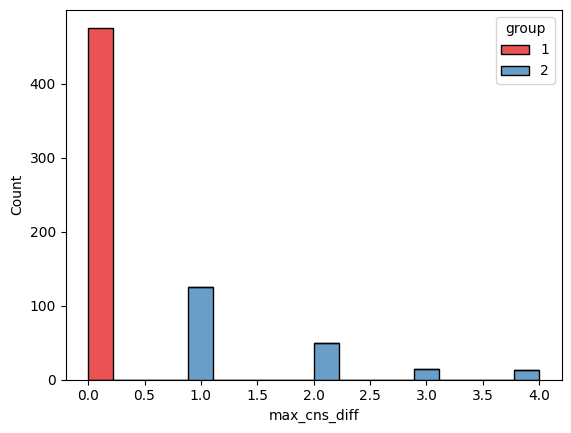

In [7]:
sns.histplot(
    design_matrix_train,
    x="max_cns_diff",
    hue="group",
    palette="Set1",
    multiple="stack"
)

In [8]:
design_matrix_train['group'].value_counts()

group
1    476
2    202
Name: count, dtype: int64

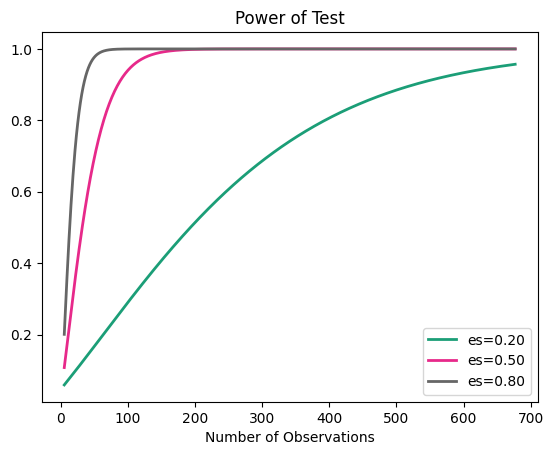

In [9]:
from statsmodels.stats.power import TTestIndPower
import matplotlib.pyplot as plt

# parameters for power analysis
effect_sizes = np.array([0.2, 0.5, 0.8])
sample_sizes = np.array(range(5, design_matrix_train.shape[0]))


analysis = TTestIndPower()

analysis.plot_power(dep_var='nobs', nobs=sample_sizes, effect_size=effect_sizes)
plt.show()

In [10]:
quant_matrix_train = preprocess_data(ms_data, design_matrix=design_matrix_train)

In [11]:
quant_matrix_train = quant_matrix_train.compare(
    method="linregress",
    comparisons=(2,1),
    min_samples_per_group=2,
    level="protein",
    multiple_testing_correction_method="fdr_tsbh"
)

In [12]:
quant_matrix_train.write("de_results/cns_de_proteins.tsv")

In [13]:
quant_matrix_de = quant_matrix_train.to_df()

<Axes: xlabel='Log2FoldChange2-1', ylabel='-Log10CorrectedPValue2-1'>

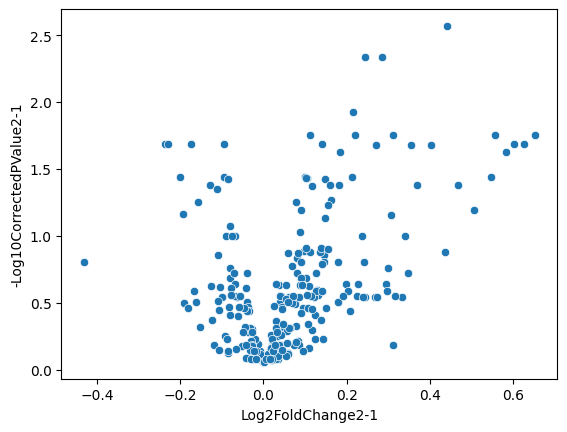

In [14]:
sns.scatterplot(
    data=quant_matrix_de,
    x="Log2FoldChange2-1",
    y="-Log10CorrectedPValue2-1"
)

In [15]:
qm_filtered = (
    
    QuantMatrix(
        quantification_file=quant_matrix_de,
        design_matrix_file=design_matrix_train
    )
    
)

In [16]:
training_data, y = qm_filtered.to_ml(feature_column="ProteinLabel")

In [17]:
protein_columns = training_data.columns.to_list()

In [18]:
len(protein_columns)

287

In [19]:
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.impute import SimpleImputer

X = training_data.copy()

protein_scaler = StandardScaler()

X[protein_columns] = protein_scaler.fit_transform(X[protein_columns])

X = X.copy()

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier


protein_clf = LogisticRegression(
    random_state=42,
    #penalty="l1",
    class_weight="balanced",
    #C=0.1,
    #solver="liblinear",
    max_iter=1000
)

# protein_clf = BaggingClassifier(
#     estimator=protein_clf,
#     random_state=42
# )

In [21]:
from cleanlab.filter import find_label_issues
from sklearn.model_selection import cross_val_predict

pred_probs = cross_val_predict(protein_clf, X, y.values.ravel(), cv=3, method="predict_proba")

label_issues = find_label_issues(
    labels=y.values.ravel(),
    pred_probs=pred_probs,
    return_indices_ranked_by='self_confidence'  # Ranks by likelihood of being mislabeled
)

/srv/data1/home/aaron/envs/miniconda3/envs/revisionenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [22]:
mask = np.ones(len(y.values.ravel()), dtype=bool)

mask[label_issues] = False

In [23]:
X = X.iloc[mask, :].copy()
y = y.iloc[mask, :].copy()

In [24]:
y['label'].value_counts()

label
0    332
1     86
Name: count, dtype: int64

In [25]:
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight


class_weight = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y.values.ravel()),
    y=y.values.ravel()
)

class_weight = dict(zip(np.unique(y.values.ravel()), class_weight))

class_weight

{0: 0.6295180722891566, 1: 2.4302325581395348}

In [26]:
len(protein_columns)

287

In [27]:
from mrmr import mrmr_classif
selected_proteins = mrmr_classif(X=X[protein_columns], y=y.values.ravel(), K=50)

100%|██████████| 50/50 [00:17<00:00,  2.90it/s]


In [28]:
selected_proteins

['CYTC_HUMAN',
 'PON3_HUMAN',
 'PRDX2_HUMAN',
 'CFAB_HUMAN',
 'H4_HUMAN',
 'C1QA_HUMAN',
 'CRAC1_HUMAN',
 'IBP2_HUMAN',
 'PROF1_HUMAN',
 'FETUB_HUMAN',
 'CSPG2_HUMAN',
 'PZP_HUMAN',
 'PPIA_HUMAN',
 'CNDP1_HUMAN',
 'GP1BA_HUMAN',
 'PSPB_HUMAN',
 'B2MG_HUMAN',
 'NCHL1_HUMAN',
 'RS27A_HUMAN',
 'APOB_HUMAN',
 'EIF3M_HUMAN',
 'ANGT_HUMAN',
 'LYSC_HUMAN',
 'CXCL7_HUMAN',
 'HLAB_HUMAN',
 'ALS_HUMAN',
 'ACTG_HUMAN',
 'CO6A1_HUMAN',
 'VCAM1_HUMAN',
 'C1QC_HUMAN',
 'PXDC2_HUMAN',
 'VWF_HUMAN',
 'RNAS1_HUMAN',
 'IBP3_HUMAN',
 'TPM3_HUMAN',
 'CO7_HUMAN',
 'LDHA_HUMAN',
 'TIMP1_HUMAN',
 'C1QB_HUMAN',
 'IC1_HUMAN',
 'LG3BP_HUMAN',
 'SODE_HUMAN',
 'TSP1_HUMAN',
 'CO6A3_HUMAN',
 'FHR4_HUMAN',
 'SODC_HUMAN',
 'K2C1_HUMAN',
 'FETUA_HUMAN',
 'C163A_HUMAN',
 'HSP7C_HUMAN']

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier


protein_clf = LogisticRegression(
    class_weight=class_weight,
    random_state=42
)

In [30]:
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_validate

cv = StratifiedKFold(3)
eval_result = cross_validate(
    protein_clf, X[selected_proteins], y.values.ravel(), scoring=("recall", "precision", "accuracy", "balanced_accuracy"), cv=cv, #params={"sample_weight": sample_weight}
)
eval_result['test_recall'].mean(), eval_result['test_precision'].mean(), eval_result['test_accuracy'].mean(), eval_result['test_balanced_accuracy'].mean()

(0.6395730706075534,
 0.46259974259974257,
 0.7654676258992805,
 0.718953884471126)

In [31]:
from dpks.interpretation import BootstrapInterpreter

protein_interpreter = BootstrapInterpreter(
    n_iterations=100,
    feature_names=selected_proteins,
    downsample_background=True,
    shuffle_iterations=100
)

In [32]:
protein_interpreter.fit(X[selected_proteins].values, y.values.ravel(), protein_clf)

In [33]:
protein_importances = protein_interpreter.results_.sort_values("mean_importance", ascending=False)

In [34]:
protein_importances.head(20)

,feature,iteration_0_importance,iteration_0_rank,iteration_1_importance,iteration_1_rank,iteration_2_importance,iteration_2_rank,iteration_3_importance,iteration_3_rank,iteration_4_importance,...,iteration_98_importance,iteration_98_rank,iteration_99_importance,iteration_99_rank,mean_importance,median_importance,stdev_importance,mean_rank,median_rank,stdev_rank
3,CFAB_HUMAN,1.000000,1.0,0.526459,7.0,1.000000,1.0,0.547283,5.0,0.889638,...,0.771656,3.0,0.870867,2.0,0.757312,0.806221,0.246473,6.09,3.0,8.428062
28,VCAM1_HUMAN,0.317071,20.0,0.872858,2.0,0.825981,4.0,0.799399,2.0,1.000000,...,0.144754,38.0,0.606035,8.0,0.623125,0.648619,0.274813,10.06,6.0,10.338532
6,CRAC1_HUMAN,0.122196,42.0,1.000000,1.0,0.590060,8.0,0.531232,6.0,0.520362,...,0.584952,8.0,0.633168,5.0,0.609163,0.581597,0.298533,11.43,6.5,12.412323
19,APOB_HUMAN,0.551733,5.0,0.809127,3.0,0.810127,5.0,0.503415,8.0,0.040112,...,0.455095,16.0,0.561458,11.0,0.553677,0.550036,0.227976,11.13,8.0,9.968288
44,FHR4_HUMAN,0.501793,6.0,0.767398,4.0,0.498143,13.0,0.316902,19.0,0.519047,...,0.868733,2.0,0.629339,6.0,0.525507,0.515041,0.249459,12.93,9.5,11.291594
4,H4_HUMAN,0.661658,3.0,0.472714,10.0,0.693577,7.0,0.395208,15.0,0.590990,...,0.448467,17.0,0.310287,22.0,0.470335,0.456385,0.186602,14.13,12.0,9.281953
8,PROF1_HUMAN,0.233130,31.0,0.066742,45.0,0.699575,6.0,0.132853,36.0,0.249956,...,0.761463,4.0,1.000000,1.0,0.448732,0.411638,0.277972,17.63,15.0,13.933939
33,IBP3_HUMAN,0.152145,39.0,0.535595,6.0,0.296820,25.0,0.637299,4.0,0.407194,...,0.537713,10.0,0.325390,21.0,0.446769,0.409614,0.259184,17.25,15.5,12.834907
11,PZP_HUMAN,0.392052,16.0,0.346923,16.0,0.378957,21.0,1.000000,1.0,0.180425,...,0.639278,5.0,0.621010,7.0,0.424451,0.391239,0.221481,17.61,14.0,12.253134
12,PPIA_HUMAN,0.454593,9.0,0.179663,26.0,0.391415,19.0,0.321996,18.0,0.553385,...,0.181977,30.0,0.418453,17.0,0.410817,0.401061,0.251642,18.80,15.5,14.121407


In [35]:
selected_proteins = protein_importances.head(10)['feature'].to_list()

In [36]:
from dpks.interpretation import Classifier


protein_clf = Classifier(protein_clf)

In [37]:
selected_features = selected_proteins[:10]

In [38]:
for feature in selected_features:

    print(feature)

CFAB_HUMAN
VCAM1_HUMAN
CRAC1_HUMAN
APOB_HUMAN
FHR4_HUMAN
H4_HUMAN
PROF1_HUMAN
IBP3_HUMAN
PZP_HUMAN
PPIA_HUMAN


In [39]:
protein_clf = LogisticRegression(
    class_weight=class_weight,
    random_state=42
)

In [40]:
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_validate

cv = StratifiedKFold(3, shuffle=True, random_state=42)
eval_result = cross_validate(
    protein_clf, X[selected_features], y.values.ravel(), scoring=("recall", "precision", "accuracy", "balanced_accuracy"), cv=cv, #params={"sample_weight": sample_weight}
)
eval_result['test_recall'].mean(), eval_result['test_precision'].mean(), eval_result['test_accuracy'].mean(), eval_result['test_balanced_accuracy'].mean()

(0.7327586206896551,
 0.5083080040526848,
 0.7990407673860912,
 0.7744737684392856)

In [41]:
cv = StratifiedKFold(3, shuffle=True, random_state=42)
eval_result = cross_validate(
    protein_clf, X[protein_columns], y.values.ravel(), scoring=("recall", "precision", "accuracy", "balanced_accuracy"), cv=cv, #params={"sample_weight": sample_weight}
)
eval_result['test_recall'].mean(), eval_result['test_precision'].mean(), eval_result['test_accuracy'].mean(), eval_result['test_balanced_accuracy'].mean()

(0.6416256157635468,
 0.7176767676767676,
 0.8755909558067833,
 0.7891720762410417)

In [42]:
from dpks.interpretation import BootstrapInterpreter

final_protein_interpreter = BootstrapInterpreter(
    n_iterations=100,
    feature_names=selected_features,
    downsample_background=True,
    shuffle_iterations=100
)

In [43]:
final_protein_interpreter.fit(X[selected_features].values, y.values.ravel(), protein_clf)

In [44]:
final_protein_importances = final_protein_interpreter.results_.sort_values("mean_importance", ascending=False)

In [45]:
final_protein_importances

,feature,iteration_0_importance,iteration_0_rank,iteration_1_importance,iteration_1_rank,iteration_2_importance,iteration_2_rank,iteration_3_importance,iteration_3_rank,iteration_4_importance,...,iteration_98_importance,iteration_98_rank,iteration_99_importance,iteration_99_rank,mean_importance,median_importance,stdev_importance,mean_rank,median_rank,stdev_rank
0,CFAB_HUMAN,1.000000,1.0,0.462387,4.0,1.000000,1.0,0.731411,2.0,0.968143,...,0.657256,2.0,1.000000,1.0,0.779773,0.848561,0.235494,2.98,2.0,2.335410
2,CRAC1_HUMAN,0.624008,5.0,1.000000,1.0,0.716688,4.0,0.235411,9.0,0.429323,...,0.391419,9.0,0.512013,6.0,0.679481,0.697486,0.278896,4.29,3.0,3.012751
3,APOB_HUMAN,0.385843,6.0,0.760198,2.0,0.851124,2.0,0.370326,6.0,0.629612,...,0.648326,3.0,0.413021,7.0,0.599615,0.583150,0.242387,4.64,4.5,2.337745
8,PZP_HUMAN,0.640817,4.0,0.315340,7.0,0.647482,7.0,1.000000,1.0,0.771401,...,0.620473,4.0,0.534545,4.0,0.571136,0.559114,0.227074,5.08,5.0,2.393932
9,PPIA_HUMAN,0.875671,2.0,0.307097,8.0,0.648323,6.0,0.481072,5.0,1.000000,...,0.341669,10.0,0.518962,5.0,0.552788,0.557992,0.232711,5.25,5.0,2.532117
6,PROF1_HUMAN,0.189301,9.0,0.211549,9.0,0.640167,8.0,0.303577,8.0,0.700550,...,1.000000,1.0,0.615786,3.0,0.514288,0.482632,0.266577,5.73,6.0,2.919302
5,H4_HUMAN,0.658496,3.0,0.417559,5.0,0.845853,3.0,0.648206,3.0,0.697575,...,0.428226,8.0,0.222810,9.0,0.503857,0.490544,0.219358,5.94,6.0,2.513881
4,FHR4_HUMAN,0.184002,10.0,0.599647,3.0,0.672583,5.0,0.306288,7.0,0.710351,...,0.441852,7.0,0.750513,2.0,0.467893,0.466213,0.258457,6.27,7.0,2.784717
7,IBP3_HUMAN,0.211537,7.0,0.158008,10.0,0.165782,10.0,0.516456,4.0,0.137371,...,0.484393,6.0,0.324491,8.0,0.431946,0.407490,0.248606,6.72,7.0,2.494762
1,VCAM1_HUMAN,0.203824,8.0,0.361008,6.0,0.259503,9.0,0.008038,10.0,0.094558,...,0.487873,5.0,0.022582,10.0,0.295984,0.260490,0.215833,8.10,9.0,2.076808


In [46]:
final_protein_importances.to_csv(
    "feature_importances/cns_protein_importances.tsv",
    sep="\t",
    index=False
)

# Model Testing

In [47]:
ms_data_test = pd.read_csv(
    "../0_data/proteins_test_filtered.tsv"
    , sep="\t"
)
design_matrix_test = pd.read_csv(
    "../0_data/design_matrix_test.tsv",
    sep='\t'
)

In [48]:
design_matrix_test = preprocess_design_matrix(design_matrix_test)

quant_matrix_test = preprocess_data(ms_data_test, design_matrix=design_matrix_test)

In [49]:
quant_matrix_test_df = quant_matrix_test.to_df()
#quant_matrix_test_df = quant_matrix_test_df[quant_matrix_test_df['ProteinLabel'].isin(selected_features)]

In [50]:
qm_filtered_test = (
    
    QuantMatrix(
        quantification_file=quant_matrix_test_df,
        design_matrix_file=design_matrix_test
    )
    
)

In [51]:
testing_data, y_test = qm_filtered_test.to_ml(feature_column="ProteinLabel")

In [52]:
X_test = testing_data.copy()

X_test[protein_scaler.feature_names_in_] = protein_scaler.transform(X_test[protein_scaler.feature_names_in_])

X_test = X_test.copy()

In [53]:
from sklearn.linear_model import LogisticRegression

from xgboost import XGBClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier

decision_tree = DecisionTreeClassifier(random_state=42)
random_forest = RandomForestClassifier(random_state=42)
svc = SVC(random_state=42)
knn = KNeighborsClassifier()
naive_bayes = GaussianNB()
mlp = MLPClassifier(random_state=42)


lr_clf = LogisticRegression(
    class_weight=class_weight,
    random_state=42
)

# lr_clf = BaggingClassifier(
#     estimator=lr_clf,
#     random_state=42,
# )

# lr_clf = BaggingClassifier(
#     estimator=random_forest,
#     random_state=42,
# )

xgb_clf = XGBClassifier(
    max_depth=5,
    min_child_weight=5,
    gamma=0.1,
    reg_alpha=0.1,
    reg_lambda=1.0,
    learning_rate=0.01,
    n_estimators=1000,
    objective='binary:logistic',
    random_state=42,
    eval_metric='logloss',
    n_jobs=1
)


In [54]:
lr_clf.fit(X[selected_features], y.values.ravel(), )
xgb_clf.fit(X[selected_features], y.values.ravel(), )
decision_tree.fit(X[selected_features], y.values.ravel(), ) 
random_forest.fit(X[selected_features], y.values.ravel(), )
svc.fit(X[selected_features], y.values.ravel(), )
knn.fit(X[selected_features], y.values.ravel()) 
naive_bayes.fit(X[selected_features], y.values.ravel(), ) 
mlp.fit(X[selected_features], y.values.ravel())

MLPClassifier(random_state=42)

In [55]:
from sklearn.metrics import f1_score

lr_predictions = lr_clf.predict(X_test[selected_features])
lr_ba = f1_score(y_test.values.ravel(), lr_predictions)

xgb_predictions = xgb_clf.predict(X_test[selected_features])
xgb_ba = f1_score(y_test.values.ravel(), xgb_predictions)

decision_tree_predictions = decision_tree.predict(X_test[selected_features])
decision_tree_ba = f1_score(y_test.values.ravel(), decision_tree_predictions)

rf_predictions = random_forest.predict(X_test[selected_features])
rf_ba = f1_score(y_test.values.ravel(), rf_predictions)

svc_predictions = svc.predict(X_test[selected_features])
svc_ba = f1_score(y_test.values.ravel(), svc_predictions)

knn_predictions = knn.predict(X_test[selected_features])
knn_ba = f1_score(y_test.values.ravel(), knn_predictions)

nb_predictions = naive_bayes.predict(X_test[selected_features])
nb_ba = f1_score(y_test.values.ravel(), nb_predictions)

mlp_predictions = mlp.predict(X_test[selected_features])
mlp_ba = f1_score(y_test.values.ravel(), mlp_predictions)

In [56]:
lr_ba, xgb_ba, decision_tree_ba, rf_ba, svc_ba, knn_ba, nb_ba, mlp_ba

(0.4666666666666667,
 0.23300970873786409,
 0.2947976878612717,
 0.1978021978021978,
 0.18115942028985507,
 0.16974169741697417,
 0.19863013698630136,
 0.2803738317757009)

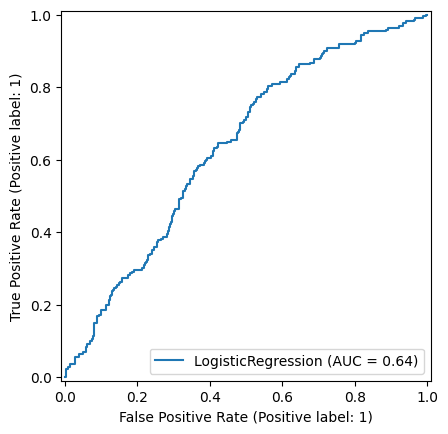

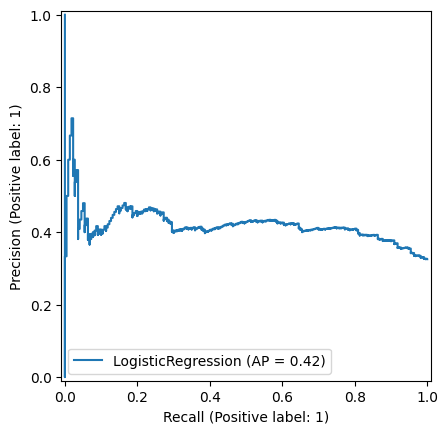

In [57]:
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay

RocCurveDisplay.from_estimator(
    lr_clf, X_test[selected_features], y_test.values.ravel()
)


PrecisionRecallDisplay.from_estimator(
    lr_clf, X_test[selected_features], y_test.values.ravel()
)





In [58]:
from sklearn.metrics import roc_curve

y_probs = lr_clf.predict_proba(X_test[selected_features])[:, 1]

# Compute ROC curve metrics
fpr, tpr, thresholds = roc_curve( y_test.values.ravel(), y_probs)

# Create a DataFrame to store the metrics
roc_df = pd.DataFrame({
    'False Positive Rate': fpr,
    'True Positive Rate': tpr,
    'Threshold': thresholds
})


In [59]:
roc_df.to_csv(
    "roc/cns.tsv",
    sep="\t"
)

# Probability Prediction

In [60]:
design_matrix_test = pd.read_csv(
    "../0_data/design_matrix_test.tsv",
    sep='\t'
)

design_matrix_test['sample'] = design_matrix_test['injection']
design_matrix_test['group'] = 1

quant_matrix_predict = QuantMatrix(
    quantification_file=ms_data_test,
    design_matrix_file=design_matrix_test,
    annotation_fasta_file="../0_data/2023-04-24-UP000005640.fas"
).impute(method="uniform_percentile", percentile=0.01)

predict_data, y_test_alll = quant_matrix_predict.to_ml(feature_column="ProteinLabel")

In [61]:
predict_data = predict_data[protein_columns].copy()

In [62]:
predict_data[protein_columns] = protein_scaler.transform(predict_data[protein_columns])

In [63]:
predict_data['cns_probability'] = lr_clf.predict_proba(predict_data[selected_features])[:, 1]

In [64]:
design_matrix_test = design_matrix_test.set_index("injection").join(
    predict_data['cns_probability']
).reset_index()

In [65]:
predict_data[['cns_probability']].to_csv(
    "predictions_test/cns.tsv",
    sep="\t"
)

<Axes: xlabel='cns_probability', ylabel='Count'>

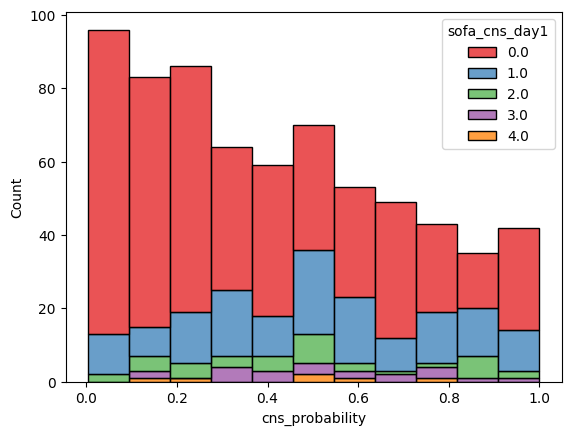

In [66]:
sns.histplot(
    data=design_matrix_test,
    x="cns_probability",
    hue="sofa_cns_day1",
    palette="Set1", 
    #kde=True,
    multiple="stack"
)

In [67]:
ms_data_val = pd.read_csv(
    "../0_data/proteins_val_filtered.tsv"
    , sep="\t"
)

design_matrix_val = pd.read_csv(
    "../0_data/design_matrix_validation.tsv",
    sep='\t'
)

design_matrix_val['sample'] = design_matrix_val['injection']
design_matrix_val['group'] = 1

quant_matrix_val = QuantMatrix(
    quantification_file=ms_data_val,
    design_matrix_file=design_matrix_val,
    annotation_fasta_file="../0_data/2023-04-24-UP000005640.fas"
)

val_data, y_val = quant_matrix_val.to_ml(feature_column="ProteinLabel")

In [68]:
val_data = val_data[protein_columns].copy()

In [69]:
val_data[protein_columns] = protein_scaler.transform(val_data[protein_columns])

In [70]:
val_data['cns_probability'] = lr_clf.predict_proba(val_data[selected_features])[:, 1]

In [71]:
design_matrix_val = design_matrix_val.set_index("injection").join(
    val_data['cns_probability']
).reset_index()

In [72]:
val_data[['cns_probability']].to_csv(
    "predictions_val/cns.tsv",
    sep="\t"
)

<Axes: xlabel='cns_probability', ylabel='Count'>

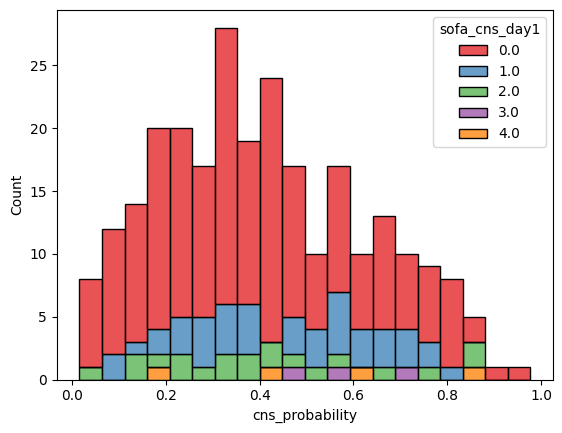

In [73]:
sns.histplot(
    data=design_matrix_val,
    x="cns_probability",
    hue="sofa_cns_day1",
    palette="Set1", 
    #kde=True,
    multiple="stack", 
    bins=20
)

In [74]:
ms_data_hero = pd.read_csv(
    "../0_data/proteins_hero_filtered.tsv"
    , sep="\t"
)

design_matrix_hero = pd.read_csv(
    "../0_data/design_matrix_hero.tsv",
    sep='\t'
)

design_matrix_hero['sample'] = design_matrix_hero['injection']
design_matrix_hero['group'] = 1

quant_matrix_hero = QuantMatrix(
    quantification_file=ms_data_hero,
    design_matrix_file=design_matrix_hero,
    annotation_fasta_file="../0_data/2023-04-24-UP000005640.fas"
)

hero_data, y_hero = quant_matrix_hero.to_ml(feature_column="ProteinLabel")

In [75]:
hero_data = hero_data[protein_columns].copy()

In [76]:
hero_data[protein_columns] = protein_scaler.transform(hero_data[protein_columns])

In [77]:
hero_data['cns_probability'] = lr_clf.predict_proba(hero_data[selected_features])[:, 1]

In [78]:
design_matrix_hero = design_matrix_hero.set_index("injection").join(
    hero_data['cns_probability']
).reset_index()

In [79]:
hero_data[['cns_probability']].to_csv(
    "predictions_external/cns.tsv",
    sep="\t"
)

<Axes: xlabel='cns_probability', ylabel='Count'>

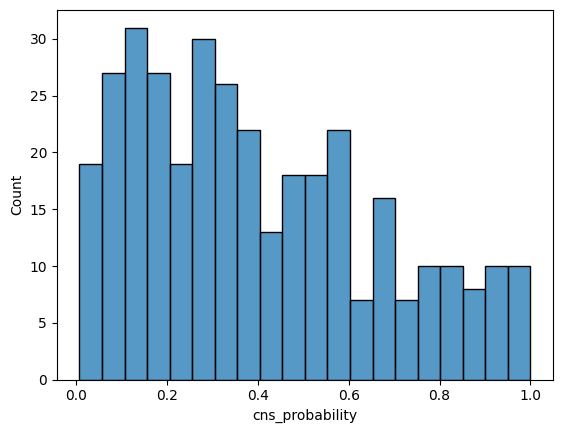

In [80]:
sns.histplot(
    data=hero_data,
    x="cns_probability",
    #hue="sofa_cns_day1",
    palette="Set1", 
    #kde=True,
    multiple="stack", 
    bins=20
)

In [81]:
from joblib import dump


with open("models/cns_protein_model.pkl", "wb") as f:

    dump(lr_clf, f)

with open("models/cns_protein_scaler.pkl", "wb") as f:

    dump(protein_scaler, f)
